In [65]:
import matplotlib.pyplot as plt
import multiprocessing as mp

import numpy as np
from sklearn.datasets import fetch_openml
from tqdm import tqdm

# Load the MNIST dataset
mnist = fetch_openml('mnist_784', parser='auto')
X, y = mnist['data'][:35000].values, mnist['target'][:35000].values

In [56]:
def recognize_symbol(reference_images, image, symbol_index_to_skip):
    # Compute the similarity between the noisy image and the reference images
    similarities = []
    for idx, ref_image in tqdm(enumerate(reference_images), total=len(reference_images)):
        if idx == symbol_index_to_skip: continue
        similarity = np.sum((np.equal(ref_image, image)).astype(int)) / image.size
#         similarity = calculate_likelihood_mp(ref_image)
        similarities.append(similarity)
    return np.argmax(similarities)

In [39]:
def generate_noisy_image(symbol_index, noise_level):
    image = X[symbol_index].reshape(28, 28)

    # Add Bernoulli noise to the image
    noisy_image = np.where(np.random.rand(*image.shape) < noise_level, 1, image)

    return image, noisy_image

In [40]:
def calculate_log_probability(image, i, j):
    pixel = np.clip(image[i, j], 1e-6, 1 - 1e-6)
    return np.where(pixel == 0, np.log(1 - pixel), np.log(pixel))

In [41]:
def calculate_likelihood_mp(image):
    with mp.Pool(mp.cpu_count()) as pool:
        # Calculate the logarithm of the probability of each pixel in parallel
        log_probabilities = pool.starmap(calculate_log_probability, [(image, i, j) for i, j in zip(*np.where(image == 0))])
    
    return sum(log_probabilities)

100%|██████████████████████████████████| 35000/35000 [00:00<00:00, 88466.04it/s]


17986 15138
Original symbol: 1
Recognized symbol: 1


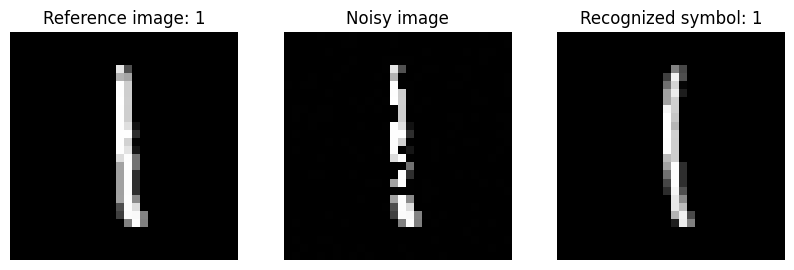

In [72]:
symbol_label = '1'
noise_level = 0.2

symbol_index = np.random.choice(np.where(y == symbol_label)[0])

# Generate a noisy image
reference_image, noisy_image = generate_noisy_image(symbol_index, noise_level)

# Recognize the symbol in the noisy image
recognized_symbol_index = recognize_symbol(X.reshape(-1, 28, 28), noisy_image, symbol_index)

print(symbol_index, recognized_symbol_index)
print(f'Original symbol: {symbol_label}')
print(f'Recognized symbol: {y[recognized_symbol_index]}')

# Display the reference image, the noisy image, and the recognition result
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

axs[0].imshow(reference_image, cmap='gray')
axs[0].set_title(f'Reference image: {symbol_label}')
axs[1].imshow(noisy_image, cmap='gray')
axs[1].set_title('Noisy image')
axs[2].imshow(X[recognized_symbol_index].reshape(28, 28), cmap='gray')
axs[2].set_title(f'Recognized symbol: {y[recognized_symbol_index]}')

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')

plt.show()